# ML в Биологии
## 13. DoWhy

In [2]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
from dowhy import gcm

from dowhy.gcm import StructuralCausalModel, EmpiricalDistribution, ClassifierFCM
from dowhy.gcm import interventional_samples
from dowhy import CausalModel
import dowhy.datasets

import networkx as nx
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

options = {
    "font_size": 14,
    "node_size": 1500,
    "node_color": "#99FF99",
    "edge_color": "#9999FF",
    "arrowsize": 25,
    "width": 3,
}

def draw_graph(graphs, options):
    nx.draw_networkx(graphs, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")

sns.set(style='whitegrid', palette='Set2')

## Задача 1

Загрузите <a href="https://github.com/robjellis/lalonde">данные</a> об исследовании влияния эффективности программы профессиональной переподготовки по отношению к реальному заработку человека через пару лет после завершения программы (в 1978). Данные также содержат несколько демографических показателей &mdash; возраст, раса, академическое образование и предыдущий заработок.

По аналогии с задачей 2 семинара 13 для имеющихся данных постройте граф причинно-следственных связей и оцените величину эффекта (и ее статистическую значимость) через ATE и ATT с помощью Propensity score, например, используя его как веса таргета (weighting) или как меру похожести при подборе тестовой группы (matching).

Описание параметров датасета:
- `treat` &mdash; были ли пройдена программа профессиональной переподготовки (1 = тестовая группа, 0 = контроль).
- `age` &mdash; возраст.
- `educ` &mdash; количество лет обучения.
- `black` &mdash; обозначение расы (1 = афроамериканец, 0 = нет).
- `hispan` &mdash; латиноамериканского происхождения (1 = да, 0 = нет).
- `married` &mdash; семейное положение (1 = женат/замужем, 0 = неженат/незамужем).
- `nodegree` &mdash; есть ли высшее образование (1 = да, 0 = нет).
- `re74` &mdash; доход в 1974 году в долларах США.
- `re75` &mdash; доход в 1975 году в долларах США.
- `re78` &mdash; доход в 1978 году в долларах США.

In [4]:
data = pd.read_csv('/content/lalonde_data.csv', index_col=0)
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
ID,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [5]:
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


**Построение DAG (граф причинно-следственных связей)**

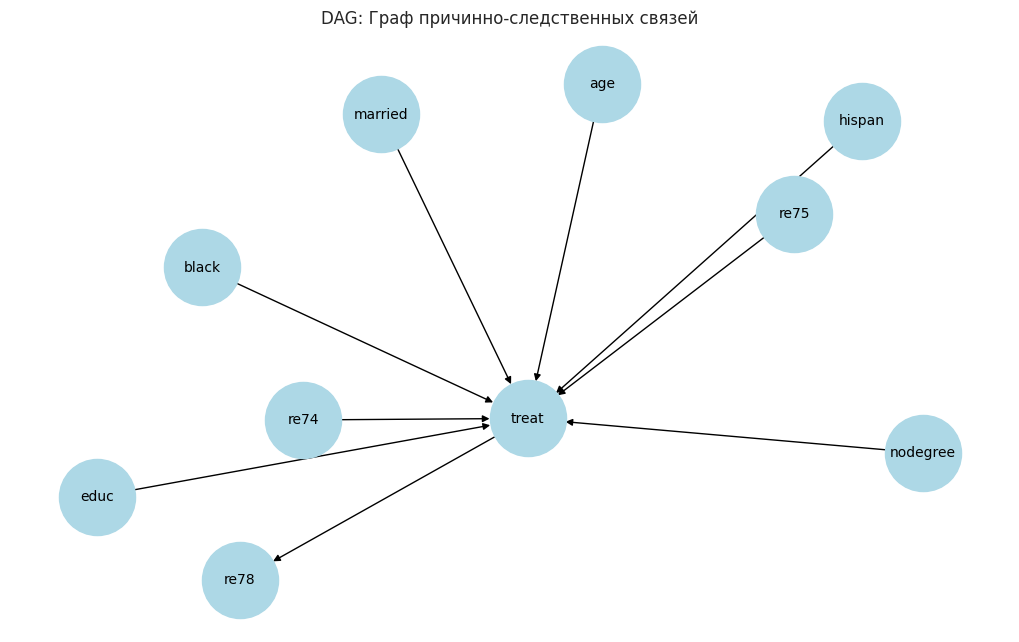

In [6]:
DAG = nx.DiGraph()
DAG.add_edges_from([
    ('age', 'treat'),
    ('educ', 'treat'),
    ('black', 'treat'),
    ('hispan', 'treat'),
    ('married', 'treat'),
    ('nodegree', 'treat'),
    ('re74', 'treat'),
    ('re75', 'treat'),
    ('treat', 're78')
])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(DAG, seed=42)
nx.draw(DAG, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.title("DAG: Граф причинно-следственных связей")
plt.show()

In [7]:
T = data['treat']  # переменная treatment
Y = data['re78']  # целевая переменная
X = data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]  # список кофаундереов

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Расчет propensity score**

In [11]:
ps_model = LogisticRegression(max_iter=1000, solver='liblinear')
ps_model.fit(X_scaled, T)
data['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]
data

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
ID,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.634047
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.224985
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.676130
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.770728
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.699798
...,...,...,...,...,...,...,...,...,...,...,...
PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.130808
PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.038186
PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.188039


**Оценка эффекта через matching**

In [13]:
nn = NearestNeighbors(n_neighbors=1)
control_group = data[data['treat'] == 0]
treated_group = data[data['treat'] == 1]

nn.fit(control_group[['propensity_score']])
distances, indices = nn.kneighbors(treated_group[['propensity_score']])
matched_controls = control_group.iloc[indices.flatten()]

ATT_matching = (treated_group['re78'].values - matched_controls['re78'].values).mean()

**Оценка эффекта через weighting**

In [14]:
weights = T / data['propensity_score'] + (1 - T) / (1 - data['propensity_score'])
ATE_weighting = np.mean(weights * (T * Y / data['propensity_score'] - (1 - T) * Y / (1 - data['propensity_score'])))

In [18]:
print(f"ATT (Matching): {ATT_matching:.2f}")
print(f"ATE (Weighting): {ATE_weighting:.2f}")

ATT (Matching): 1093.94
ATE (Weighting): 29921.89


**Выводы:**

1. **Граф причинно-следственных связей (DAG)**

Был построен граф, который отображает предполагаемые связи между демографическими характеристиками, доходом до программы (`re74`, `re75`), участием в программе профессиональной переподготовки (`treat`) и доходом через два года после программы (`re78`).

2. **ATT**:

Эффект программы на доход участников, рассчитанный методом matching, составил **1093.94 USD**. Это свидетельствует о том, что программа увеличивает доход для участвовавших в ней.

3. **ATE**:

Средний эффект программы на всю популяцию, рассчитанный методом weighting, составил **29921.89 USD**. Это предполагает значительный общий эффект программы на доход.

**Итог**:

- Программа профессиональной переподготовки положительно влияет на доходы участников, что подтверждается как методом matching, так и методом weighting.

- Различие между ATT и ATE может быть связано с неоднородностью в демографических характеристиках или начальных доходах участников и всей популяции.

---

### Задача 2

**1.** Рассмотрим данные по заболеваемости и смертности от COVID-19 в марте 2020 года, когда пандемия только начиналась. В данных представлена информация по нескольким странам по разным возрастным категориям.

Загрузите данные и рассчитайте Case Fatality Rate (CFR) &mdash; процент смертности при условии подтвержденного коронавируса (Confirmed cases).

In [40]:
data = pd.read_excel("covid_data.xlsx", index_col=0)
data.head()

,Country,Age group,Confirmed cases,Confirmed fatalities
0,Italy,0-9,43,0
1,Italy,10-19,85,0
2,Italy,20-29,296,0
3,Italy,30-39,470,0
4,Italy,40-49,891,1


Будем рассматривать Китай и Италию как довольно разные страны, в которых коронавирус в начале 2020 развивался наиболее стремительно.

Постройте гистограмму для сравнения CFR двух стран по возрастным категориям. Используйте для этого один вызов `seaborn.barplot` с необходимыми параметрами.

In [41]:
data['CFR'] = (data['Confirmed fatalities'] / data['Confirmed cases']) * 100
data

,Country,Age group,Confirmed cases,Confirmed fatalities,CFR
0,Italy,0-9,43,0,0.000000
1,Italy,10-19,85,0,0.000000
2,Italy,20-29,296,0,0.000000
3,Italy,30-39,470,0,0.000000
4,Italy,40-49,891,1,0.112233
...,...,...,...,...,...
103,South Korea,40-49,1481,3,0.202566
104,South Korea,50-59,1987,15,0.754907
105,South Korea,60-69,1375,39,2.836364
106,South Korea,70-79,719,78,10.848401


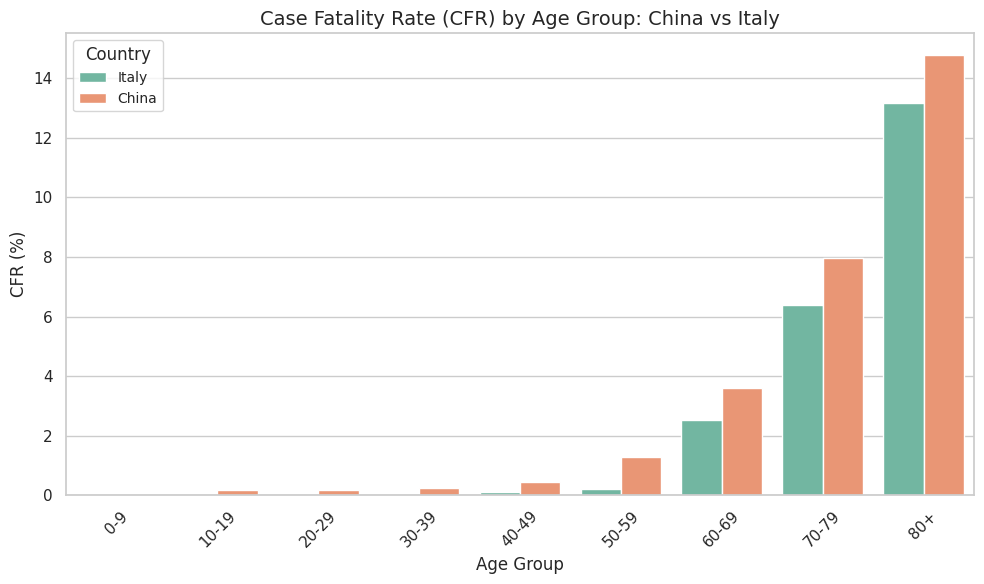

In [42]:
countries_of_interest = ['China', 'Italy']
data_filtered = data[data['Country'].isin(countries_of_interest)]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_filtered,
    x='Age group',
    y='CFR',
    hue='Country',
    palette='Set2'
)

plt.title('Case Fatality Rate (CFR) by Age Group: China vs Italy', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('CFR (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Country', fontsize=10)
plt.tight_layout()

plt.show()

Теперь рассчитайте общую CFR на основе суммарного количества случаев по всем возрастным категориями и сравните их для этих двух стран.

In [43]:
summary_data = data[data['Country'].isin(['China', 'Italy'])].groupby('Country').agg(
    total_cases=('Confirmed cases', 'sum'),
    total_fatalities=('Confirmed fatalities', 'sum')
).reset_index()

summary_data['CFR'] = (summary_data['total_fatalities'] / summary_data['total_cases']) * 100
summary_data

,Country,total_cases,total_fatalities,CFR
0,China,44672,1023,2.290025
1,Italy,8026,357,4.448044


Что можно наблюдать?

Китай: Общая CFR составляет 2.29%.
Италия: Общая CFR равна 4.45%, что примерно в 2 раза выше, чем в Китае. Но при этом в старших возрастных группах (70-79 и 80+) CFR в Китае выше, чем в Италии

**2.** Итак, мы исследуем три признака: страна, возрастная категория, CFR. Определите на них граф причинно-следственных связей на основе логических соображений и визуализируйте его.

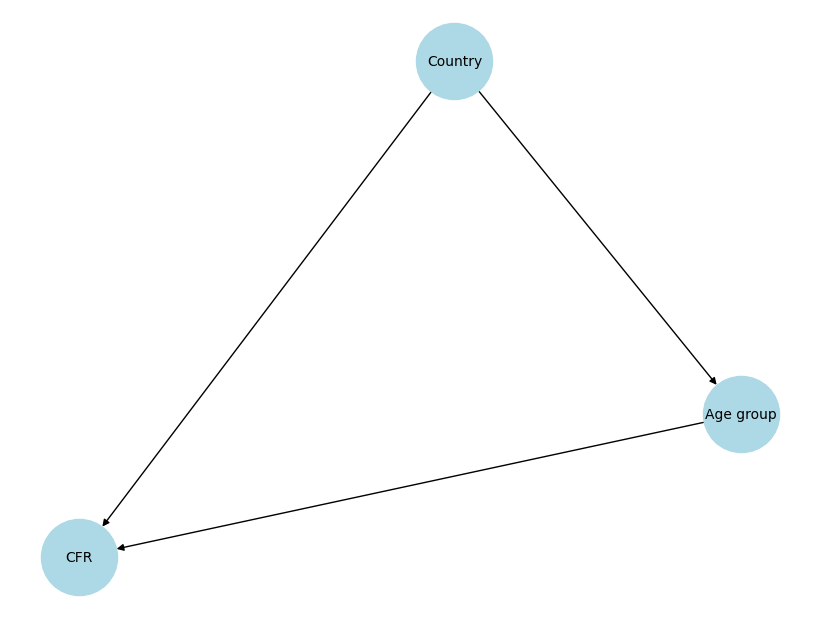

In [44]:
causal_graph = nx.DiGraph()

causal_graph.add_nodes_from(["Country", "Age group", "CFR"])

causal_graph.add_edge("Country", "CFR")
causal_graph.add_edge("Age group", "CFR")
causal_graph.add_edge("Country", "Age group")

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(causal_graph, seed=42)
nx.draw(causal_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.show()

Для каждой вершины опишите характер причинно-следственной связи. Например, если это линейная регрессия, то надо *выписать ее формулу*.

### Описание причинно-следственных связей

1. **Country $\rightarrow$ Age group:**  
Страна влияет на возрастную категорию через демографическую структуру населения.  
   
**Формула:**

$$
\text{Age group} = \alpha_0 + \alpha_1 \cdot \text{Country}
$$

2. **Country $\rightarrow$ CFR:**

Страна влияет на Case Fatality Rate (CFR) через доступность медицины, качество здравоохранения и другие факторы.

**Формула:**

$$
\text{CFR} = \beta_0 + \beta_1 \cdot \text{Country}
$$

3. **Age group $\rightarrow$ CFR**  

Возрастная категория напрямую влияет на вероятность летального исхода из-за различий в иммунной системе.  

**Формула:**

$$
\text{CFR} = \gamma_0 + \gamma_1 \cdot \text{Age group}
$$

### Итоговая модель CFR:

$$
\text{CFR} = \delta_0 + \delta_1 \cdot \text{Country} + \delta_2 \cdot \text{Age group}
$$

**3.** Сделаем две копии признака "страна":
* `demography` ($D$) &mdash; демографическая ситуация, определяемая страной;
* `treatment methods` ($T$) &mdash; методы лечения, свойственные стране.

Мы делаем такое разделение потому как, например, одна страна может взять методы лечения другой страны, но демографическую ситуацию поменять при этом не получится.

Визуализируйте причинно-следственный граф с новыми признаками вместо `Country`.

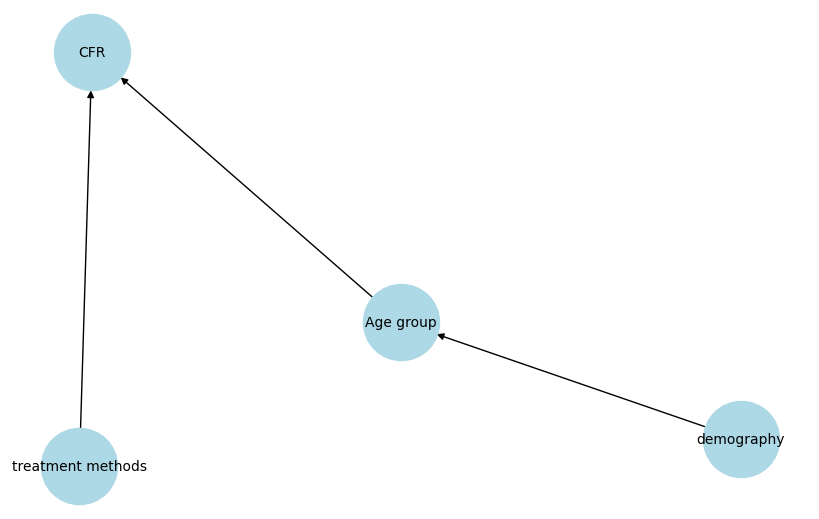

In [52]:
data_filtered['demography'] = data_filtered['Country']
data_filtered['treatment methods'] = data_filtered['Country']


causal_graph = nx.DiGraph([
    ('demography', 'Age group'),
    ('treatment methods', 'CFR'),
    ('Age group', 'CFR')
])

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(causal_graph, seed=42)
nx.draw(causal_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.show()

Определите по графу causal модель и обучите ее

In [53]:
from dowhy.gcm import AdditiveNoiseModel, ClassifierFCM
from dowhy.gcm.ml import create_linear_regressor

In [54]:
model = StructuralCausalModel(causal_graph)

model.set_causal_mechanism("demography", EmpiricalDistribution())
model.set_causal_mechanism("Age group", ClassifierFCM())
model.set_causal_mechanism("treatment methods", EmpiricalDistribution())
model.set_causal_mechanism("CFR", AdditiveNoiseModel(prediction_model=create_linear_regressor()))

gcm.fit(model, data_filtered)

Fitting causal mechanism of node CFR: 100%|██████████| 4/4 [00:00<00:00, 29.35it/s]


С помощью интервенции оцените, было бы эффективнее в Китае с его демографической ситуацией применять итальянские методы лечения. Для этого нужно оценить величину
$$NDE = \mathsf{E}(CFR\ |\ D:=China, T:=Italy) - \mathsf{E}(CFR\ |\ D:=China, T:=China),$$

где NDE &mdash; Natural Direct Effect. Используйте достаточно большое количество семплирований.

In [62]:
nde = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "China",
        "treatment methods": lambda x: "Italy"
    },
    interventions_reference={
        "demography": lambda x: "China",
        "treatment methods": lambda x: "China"
    },
    num_samples_to_draw=1000
)

nde

-0.8548432349059292

Теперь, наоборот, оцените, было бы эффективнее применять в Италии с ее демографической ситуацией китайские методы лечения.

In [63]:
nde = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "Italy",
        "treatment methods": lambda x: "China"
    },
    interventions_reference={
        "demography": lambda x: "Italy",
        "treatment methods": lambda x: "Italy"
    },
    num_samples_to_draw=1000
)

nde

0.7632253770215085

Наконец, оценим, что было бы, если в Китае с его методами лечения демографическая ситуация была бы такой же, как в Италии (Natural Indirect Effect). Какую величину при этом надо рассчитать? Рассчитайте ее.

In [72]:
nie = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "Italy",
        "treatment methods": lambda x: "China"
    },
    interventions_reference={
        "demography": lambda x: "China",
        "treatment methods": lambda x: "China"
    },
    num_samples_to_draw=1000
)

nie

0.09892767538964842

Можно также получить доверительный интервал оценки эффекта с помощью `gcm.confidence_intervals`, но, так как данный метод принимает только функции без параметров в качестве аргумента, нужно либо задать дополнительно вспомогательную функцию `def f(): return target_f(*args, **kwargs)`, либо передать `lambda`-функцию без параметров.

In [73]:
def calculate_nie():
    return gcm.average_causal_effect(
        model,
        'CFR',
        interventions_alternative={
            "demography": lambda x: "Italy",
            "treatment methods": lambda x: "China"
        },
        interventions_reference={
            "demography": lambda x: "China",
            "treatment methods": lambda x: "China"
        },
        num_samples_to_draw=1000
    )

nie_confidence_interval = gcm.confidence_intervals(
    calculate_nie,
)

print(f"NIE: {calculate_nie()}")
print(f"95% Confidence Interval: {nie_confidence_interval}")

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:01<00:00, 19.86it/s]

NIE: 0.009701361405933806
95% Confidence Interval: (array([0.03649925]), array([[-0.30104008,  0.38393997]]))


Повторите аналогичный эксперимент для Италии: если бы в этой стране применяли итальянские методы лечения, но демография была бы как в Китае.

In [74]:
def calculate_nie_italy():
    return gcm.average_causal_effect(
        model,
        'CFR',
        interventions_alternative={
            "demography": lambda x: "China",
            "treatment methods": lambda x: "Italy"
        },
        interventions_reference={
            "demography": lambda x: "Italy",
            "treatment methods": lambda x: "Italy"
        },
        num_samples_to_draw=1000
    )

nie_italy_confidence_interval = gcm.confidence_intervals(calculate_nie_italy)

print(f"NIE: {calculate_nie_italy():.2f}")
print(f"95% Confidence Interval: {nie_italy_confidence_interval}")

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:01<00:00, 19.31it/s]


NIE: 0.18
95% Confidence Interval: (array([-0.03325897]), array([[-0.20407244,  0.25651876]]))


**Выводы:**

Методы лечения имеют гораздо более сильное воздействие на показатель CFR, чем демографические факторы. Это видно из того, что значения NDE оказываются более выраженными и значимыми, чем NIE.

Итальянские методы лечения менее эффективны в контексте китайской демографии, однако китайские методы могут значительно улучшить результаты в итальянской демографической ситуации.

Демографическая ситуация Китая может немного улучшить результаты при применении итальянских методов лечения, но эффект этого изменения незначителен.

**4.** Наконец, сравните между собой некоторые другие страны на ваш выбор. Каким странам вы рекомендовали бы поменять методы лечения на начальном этапе?

In [75]:
filtered_data = data[data['Country'].isin(['USA', 'Spain'])]

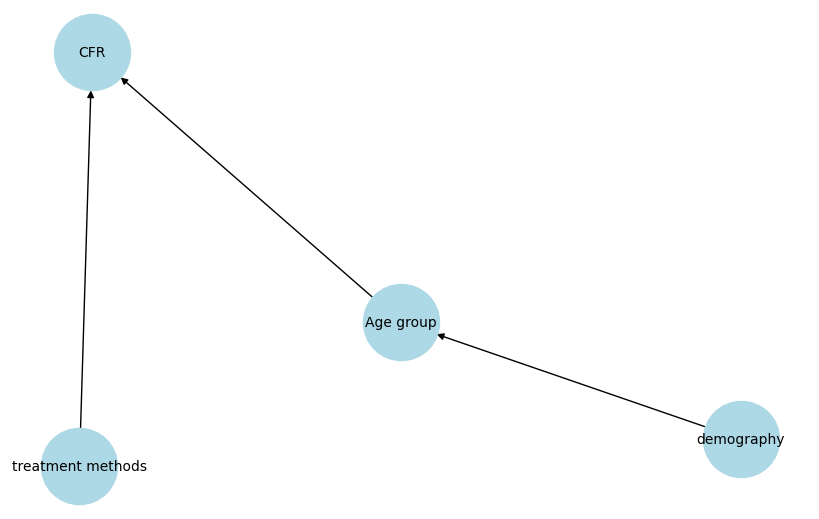

In [76]:
filtered_data['demography'] = filtered_data['Country']
filtered_data['treatment methods'] = filtered_data['Country']

causal_graph = nx.DiGraph([
    ('demography', 'Age group'),
    ('treatment methods', 'CFR'),
    ('Age group', 'CFR')
])

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(causal_graph, seed=42)
nx.draw(causal_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.show()

In [77]:
model = StructuralCausalModel(causal_graph)

model.set_causal_mechanism("demography", EmpiricalDistribution())
model.set_causal_mechanism("Age group", ClassifierFCM())
model.set_causal_mechanism("treatment methods", EmpiricalDistribution())
model.set_causal_mechanism("CFR", AdditiveNoiseModel(prediction_model=create_linear_regressor()))  #

gcm.fit(model, filtered_data)

Fitting causal mechanism of node CFR: 100%|██████████| 4/4 [00:00<00:00, 16.72it/s]


In [80]:
nde = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "Spain",
        "treatment methods": lambda x: "USA"
    },
    interventions_reference={
        "demography": lambda x: "Spain",
        "treatment methods": lambda x: "Spain"
    },
    num_samples_to_draw=1000
)

nde

-0.07832264247108522

In [81]:
nde = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "USA",
        "treatment methods": lambda x: "Spain"
    },
    interventions_reference={
        "demography": lambda x: "USA",
        "treatment methods": lambda x: "USA"
    },
    num_samples_to_draw=1000
)

nde

-0.5489150349690259

In [85]:
nie = gcm.average_causal_effect(
    model,
    'CFR',
    interventions_alternative={
        "demography": lambda x: "USA",
        "treatment methods": lambda x: "Spain"
    },
    interventions_reference={
        "demography": lambda x: "Spain",
        "treatment methods": lambda x: "Spain"
    },
    num_samples_to_draw=1000
)

nie

0.39866986467796384

In [86]:
def calculate_nie():
    return gcm.average_causal_effect(
        model,
        'CFR',
        interventions_alternative={
            "demography": lambda x: "USA",
            "treatment methods": lambda x: "Spain"
        },
        interventions_reference={
            "demography": lambda x: "Spain",
            "treatment methods": lambda x: "Spain"
        },
        num_samples_to_draw=1000
    )

nie_confidence_interval = gcm.confidence_intervals(calculate_nie)

print(f"NIE): {calculate_nie()}")
print(f"95% Confidence Interval: {nie_confidence_interval}")

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:01<00:00, 11.79it/s]


NIE): 0.06294404059020753
95% Confidence Interval: (array([0.04660437]), array([[-0.38708727,  0.56255984]]))


In [87]:
def calculate_nie_italy():
    return gcm.average_causal_effect(
        model,
        'CFR',
        interventions_alternative={
            "demography": lambda x: "USA",
            "treatment methods": lambda x: "USA"
        },
        interventions_reference={
            "demography": lambda x: "USA",
            "treatment methods": lambda x: "USA"
        },
        num_samples_to_draw=1000
    )

nie_italy_confidence_interval = gcm.confidence_intervals(calculate_nie_italy)

print(f"NIE: {calculate_nie_italy()}")
print(f"95% Confidence Interval: {nie_italy_confidence_interval}")

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:01<00:00, 18.38it/s]

NIE: 0.36665493698798013
95% Confidence Interval: (array([0.04211403]), array([[-0.51083545,  0.38782792]]))


**Выводы:**

1. Применение американских методов лечения в Испании снижает CFR, но эффект незначителен. Напротив, испанские методы в США не показывают существенного улучшения. Разница между странами минимальна.

2. Изменение демографической ситуации, например, внедрение испанской демографии в США, заметно влияет на CFR. Это подтверждает, что демографические факторы имеют большое значение.

3. Страны должны учитывать как демографию, так и методы лечения при принятии решений. Обмен методами лечения может быть полезным, но изменения в демографии также могут сыграть ключевую роль в снижении смертности.

4. Разница в демографических факторах имеет более сильное воздействие на CFR, чем методы лечения, хотя оба аспекта важно учитывать при оптимизации подходов.